In [1]:
import os
import time
import itertools
import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from torchvision.transforms import v2
import torch
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# import mediapy as media

%matplotlib inline
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
from vae_model import *
from ph_dataset import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# torchvision.disable_beta_transforms_warning()


/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <38796DC6-8F33-3A89-BBAA-5FC71F99817A> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints a

In [2]:
# Forward method
def vae_forward(
    vae: BetaVAE,
    X: torch.Tensor,
    beta: float,
    sparsity_weight:float,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        X: (N, C, 16, 16) input tensor of Cx16x16 images
        beta: KL divergence strength

    Returns:
        (,) vae loss.
    """
    # Apply positional encoding to input coordinates
    vae.train()
    recon_x, mu, logvar = vae.forward(X)
    return beta_vae_loss_function(recon_x, X, mu, logvar, beta=beta, sparsity_weight=sparsity_weight, verbose=train_config['verbose_loss'])

# Sampling method
@torch.inference_mode()
def vae_sample(
    vae: BetaVAE,
    nsamples: int,
    img_cwh: tuple[int, int],
    seed: int,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        nsamples: number of images to create
        img_cwh: image dimensions (W, H)
    Returns:
        (,) 
    """
    vae.eval()
    device = get_device()
    with torch.no_grad():
        torch.manual_seed(seed)
        z = torch.randn(nsamples, vae.latent_dim).to(device)
        return vae.decode(z).cpu()

In [3]:
# VaeWrapper: one level of indirection to make experimentation on the fly easier

class VaeWrapper(nn.Module):
    def __init__(
        self,
        vae: BetaVAE,
        input_img_cwh: tuple[int, int] = (1, 16, 16),
        seed: int = 180,
        beta=1.0,
        sparsity_weight=0.0,
    ):
        super().__init__(),
        self.vae = vae
        self.img_cwh = input_img_cwh
        self.seed = seed
        self.beta = beta
        self.sparsity_weight = sparsity_weight
        
    def forward(self, X: torch.Tensor):
        """
        Args:
            X: (N, C, 16, 16) input tensor of C x 16 x 16 images

        Returns:
            (,) VAE loss.
        """
        self.vae.train()
        assert X[0].shape == torch.Size(self.img_cwh), f"X.shape={X.shape} but img_cwh={self.img_cwh}"
        return vae_forward(self.vae, X, self.beta, self.sparsity_weight)

    @torch.inference_mode()
    def sample(
        self,
        nsamples: int = 16,
    ):
        self.vae.eval()
        return vae_sample(self.vae, nsamples, self.img_cwh, self.seed)

In [4]:
# Training helper functions
def make_training_loss_plot(log_dict, figsize=(9,6)):
    """Plot training loss vs step"""
    epoch = log_dict['Epoch'][-1]
    log_df = pd.DataFrame.from_dict(log_dict)
    plt.figure(figsize=figsize)
    sns.lineplot(
        log_df,
        x='Step',
        y='Loss',
        errorbar=None,
    )
    ax = plt.gca()
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    plt.grid(True, which="both", ls="-")
    plt.title(f'Training Loss After {epoch} Epochs')
    plt.show()

def get_device(verbose=False):
    """Returns the torch device to use for training based on detected gpu hardware."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    if verbose: print(f"Using device {device}")
    return device

def get_husl_cmap(n_categories):
    palette = sns.color_palette("husl", n_categories)
    cmap = ListedColormap(palette)
    return cmap

def colorbar_formatter(value, tick_position, use_norm_imgs=False):
    if not use_norm_imgs:
        val = ph_dataset.inv_norm(np.array([value]))[0]
    else:
        val = value
    return int(val)

def show_dataset_sample(dataset, nrows=5, ncols=15, cmap='rocket', log_cbar=False, use_norm_imgs=True):
    """Preview images from the dataset."""
    nsamples = nrows * ncols
    idxs = np.arange(len(dataset))
    sample_idxs = np.random.choice(idxs, nsamples, replace=False)
    
    if len(sample_idxs) < nsamples:
        print('Not enough training data')

    f = plt.figure(figsize=(ncols, nrows))
    # f.tight_layout()

    canvas = np.zeros((nrows * 16, ncols * 16))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        im = ph_dataset.get_ph_data(idx)['img']
        if not use_norm_imgs:
            im = ph_dataset.inv_norm(im)
        canvas[row*16:(row+1)*16, col*16:(col+1)*16] = im
    
    vmin = np.quantile(canvas, 0.005)
    img_plt = plt.imshow(canvas, cmap=cmap, vmin=vmin)
    cbar = plt.colorbar(img_plt, fraction=0.027, pad=0.025)
    plt.title("Normalized Real Pulse Height Images")
    plt.show(f)

def plot_vae_sample(model: VaeWrapper, nrows=15, ncols=25, size=16, cmap='rocket', log_cbar=False, use_norm_imgs=True):
    nsamples = nrows * ncols
    sampled_norm_ph_imgs = model.sample(nsamples).squeeze(1).numpy()
    if not use_norm_imgs:
        sampled_ph_imgs = ph_dataset.inv_norm(sampled_norm_ph_imgs)
    else:
        sampled_ph_imgs = sampled_norm_ph_imgs
    assert len(sampled_ph_imgs) == nrows * ncols
    
    # Sample from the VAE model
    ph_imgs = np.zeros((nrows * size, ncols * size))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        ph_imgs[row*size:(row+1)*size, col*size:(col+1)*size] = sampled_ph_imgs[i]
    # Plot image samples
    f = plt.figure(figsize=(ncols, nrows))
    f.tight_layout()
    
    vmin = np.quantile(ph_imgs, q=0.005)
    img_plt = plt.imshow(ph_imgs, cmap=cmap, vmin=vmin)
    cbar = plt.colorbar(img_plt, fraction=0.045, pad=0.025)
    plt.title("VAE-Generated Pulse Height Images")
    plt.show()

In [54]:
# Define a function to extract latent space representations
def extract_latent_space(vae_model, data_loader, device=get_device(), seed=42, max_latent_vectors=10000):
    """
    Extract latent space representations from the VAE.
    
    Args:
        vae_model: Trained VAE model.
        data_loader: DataLoader containing images to process.
        device: PyTorch device (e.g., 'cuda' or 'cpu').

    Returns:
        latent_vectors: List of latent vectors.
    """
    vae_model.eval()
    norm_ph_imgs = []
    latent_vectors = []
    recon_losses = []

    nbatches = len(data_loader)
    sample_batch_idxs = np.random.choice(nbatches, size=min(nbatches, max_latent_vectors // data_loader.batch_size), replace=False)
    
    with torch.no_grad():
        torch.manual_seed(seed)
        batch_idx = 0
        for x in tqdm(data_loader, unit="batch"):
            if batch_idx not in sample_batch_idxs:
                batch_idx += 1
                continue
            batch_idx += 1
            x = x.to(device)
            # Pass images through encoder
            mu, logvar = vae_model.encode(x)
            z = vae_model.reparameterize(mu, logvar)  # Get latent vector
            recon_x = vae_model.decode(z)
            # print('z shape', z.shape)
            # print('recon shape', recon_x.shape)
            recon_loss = torch.mean((x - recon_x)**2, dim=(1, 2, 3))
            # print('recon loss shape', recon_loss.shape)
            norm_ph_imgs.append(x.cpu().numpy())
            latent_vectors.append(z.cpu().numpy())
            recon_losses.append(recon_loss.cpu().numpy())
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    recon_losses = np.concatenate(recon_losses, axis=0)
    norm_ph_imgs = np.concatenate(norm_ph_imgs, axis=0).squeeze()
    return norm_ph_imgs, latent_vectors, recon_losses

def cluster_latent_space(
    latent_vectors,
    recon_losses,
    anom_q=0.98,
    reduction_method='tsne',
    clustering_method='kmeans',
    max_gmm_components = 15,
    n_components=3,
    n_clusters=9,
    seed=42
):
    """
    Reduce the dimensionality of latent space and perform clustering.
    
    Args:
        latent_vectors: Array of latent vectors (N x D).
        method: Dimensionality reduction method ('pca' or 'tsne').
        n_components: Number of dimensions to reduce to (default 3).
    
    Returns:
        reduced_data: Latent vectors reduced to n_components dimensions.
        cluster_labels: Cluster assignments from KMeans.
    """
    anom_thresh = np.quantile(recon_losses, q=anom_q)
    is_inlier = recon_losses < anom_thresh
    # inlier_latent_vectors = latent_vectors[is_inlier]

    # Reduce dimensionality of data
    if reduction_method == 'pca':
        reducer = PCA(n_components=n_components)
        reduced_data = reducer.fit_transform(latent_vectors)
    elif reduction_method == 'tsne':
        print('n latent vectors', len(latent_vectors))
        pca_reducer = PCA(n_components=min(n_components, 16))
        reducer = TSNE(n_components=n_components, perplexity=30, random_state=seed)
        print('doing pca')
        pca_reduced_data = pca_reducer.fit_transform(latent_vectors)
        print('doing tsne')
        reduced_data = reducer.fit_transform(pca_reduced_data)
    else:
        raise ValueError("reduction_method must be 'pca' or 'tsne'.")
    
    
    # Perform clustering
    if clustering_method == 'kmeans':
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed)  # Adjust number of clusters as needed
        cluster_labels = kmeans.fit_predict(reduced_data)
    elif clustering_method == 'gmm':
        # Tune GMM using BIC
        bics = []
        gmm_models = []
        component_range = range(1, max_gmm_components + 1)
        
        for n_components in component_range:
            gmm = GaussianMixture(n_components=n_components, random_state=seed)
            gmm.fit(reduced_data)
            bics.append(gmm.bic(reduced_data))
            gmm_models.append(gmm)
        
        # Select the best model
        best_n_components = component_range[np.argmin(bics)]
        best_gmm = gmm_models[np.argmin(bics)]
        print(f'doing gmm with {best_n_components} components')
        cluster_labels = best_gmm.predict(reduced_data)
        
    else:
        raise ValueError("clustering_method must be 'kmeans' or 'gmm'.")
    # Indicate anomalies  
    # cluster_labels = [('A' + str(c)) if (is_inlier[i] == False) else str(c) for i, c in enumerate(cluster_labels)]
    # print(cluster_labels)
    cluster_labels[~is_inlier] = -cluster_labels[~is_inlier]
    return reduced_data, cluster_labels, anom_thresh

def visualize_anomalies(images, cluster_labels, recon_losses, anom_thresh):
    # unique_clusters = np.unique(cluster_labels)
    # num_clusters = len(unique_clusters)

    # # colormap config
    # cmap = get_husl_cmap(num_clusters)
    # norm = BoundaryNorm(np.arange(num_clusters + 1), num_clusters)
    # fig = plt.figure(figsize=(1 * num_clusters, 8))
    # # print(len(cluster_labels), len(recon_losses), cluster_labels, recon_losses)
    # sns.boxplot(x=cluster_labels, y=recon_losses, hue=x, palette='husl')
    # plt.show()
    plt.figure(figsize=(12, 6))
    sns.histplot(recon_losses, stat='count', log_scale=True)
    plt.axvline(anom_thresh, label=f'Anomaly Threshold: {anom_thresh:0.3}')
    plt.legend()
    # plt.yscale('log')
    plt.title('Distribution of Reconstruction MSE')
    plt.show()
    

def visualize_clusters_3d_orientations(reduced_data, cluster_labels, recon_losses, anom_thresh, n_orientations=9, ncols=3, vis_anom_q=0.99):
    """
    Visualize latent clusters in 3D from multiple orientations.
    
    Args:
        reduced_data: 3D array of reduced latent space vectors.
        cluster_labels: Cluster assignments from KMeans.
    """
    vis_inlier_thresh = np.quantile(recon_losses, q=vis_anom_q)
    is_inlier = recon_losses < vis_inlier_thresh
    inlier_reduced_data = reduced_data[is_inlier]
    inlier_cluster_labels = cluster_labels[is_inlier]
    
    unique_clusters = np.unique(inlier_cluster_labels)
    sorted_unique_clusters = np.sort(unique_clusters)
    num_clusters = len(unique_clusters)
    nrows = int(np.ceil(n_orientations / ncols))


    # colormap config
    print(num_clusters)
    print(unique_clusters)
    cmap = get_husl_cmap(num_clusters)
    norm = BoundaryNorm(
        np.append(sorted_unique_clusters, np.max(sorted_unique_clusters) + 1),
        ncolors=num_clusters,
        clip=False
    )

    # create fig
    fig = plt.figure(figsize=(6 * ncols + 1, 5.2 * nrows), dpi=250)
    gs = fig.add_gridspec(nrows, ncols + 1, width_ratios=[1] * ncols + [0.07])  # Extra column for colorbar

    # Define viewing angles
    orientations = []
    titles = []
    # az_delta = 360 // n_orientations
    az_delta = 45
    for i in range(n_orientations):
        azim = i * az_delta
        orientations.append((30, azim))
        titles.append('Angle ({0}°, {1}°)'.format(30, azim))

    
    
    for i, (elev, azim) in enumerate(orientations):
        # ax = fig.add_subplot(nrows, ncols, i + 1, projection='3d')
        ax = fig.add_subplot(gs[i // ncols, i % ncols], projection='3d')
        
        # Scatter plot for clusters
        scatter = ax.scatter(
            inlier_reduced_data[:, 0], inlier_reduced_data[:, 1], inlier_reduced_data[:, 2],
            c=inlier_cluster_labels, cmap=cmap, s=1.5, norm=norm
        )
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(titles[i], pad=0.01)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')

    # Add a colorbar to the last plot
    cbar_ax = fig.add_subplot(gs[:, -1])  # Use the last column of gridspec for the colorbar
    cbar = fig.colorbar(
        scatter, cax=cbar_ax, label='Cluster #', ticks=sorted_unique_clusters+0.5,
        orientation='vertical'
    )
    cbar.ax.set_yticklabels([str(i) if i >= 0 else f'Anom {i}' for i in sorted_unique_clusters])  # Set tick labels as integers

    # Adjust layout to prevent cutoff

    # Add title
    n_gmm_components = np.sum(unique_clusters >= 0)
    fig.suptitle(f"3D PCA Representation of VAE Latent Space with {n_gmm_components}-Component GMM Clustering", y=1.02, fontsize=18)
    plt.tight_layout()
    plt.show()

# Function to randomly sample images from each cluster
def visualize_samples_per_cluster(norm_ph_imgs, latent_vectors, cluster_labels, max_n_samples=36, cmap='rocket', use_norm_imgs=False):
    """
    Visualizes n randomly sampled images from each cluster in the latent space.

    Args:
        norm_ph_imgs (numpy.ndarray): Original (ph_images) (shape: [num_samples, 1, 16, 16]).
        latent_vectors (numpy.ndarray): Latent space vectors (shape: [num_samples, latent_dim]).
        cluster_labels (numpy.ndarray): Cluster labels for each latent vector (shape: [num_samples]).
        max_n_samples (int): Max number of images to sample per cluster.
    """
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    

    # Create a figure with subplots
    fig, axes = plt.subplots(num_clusters, 1, figsize=(max_n_samples * 1, num_clusters * 2))
    fig.suptitle("Dataset Samples from Each Latent Space Cluster", fontsize=24, y=0.96)
    if use_norm_imgs:
        imgs = norm_ph_imgs
    else:
        imgs = ph_dataset.inv_norm(norm_ph_imgs)
    vmin = np.quantile(imgs, 0.005)
    # vmax = np.quantile(imgs, 0.9995)
    for cluster_idx, cluster in enumerate(reversed(unique_clusters)):
        # Get indices of all samples in this cluster
        cluster_idxs = np.where(cluster_labels == cluster)[0]
        # Randomly select n_sample indices
        sample_size = min(len(cluster_idxs), max_n_samples)
        sampled_indices = random.sample(list(cluster_idxs), sample_size)
        canvas = np.zeros((16, 16 * sample_size))
        for sidx, img_idx in enumerate(sampled_indices):
            canvas[:, sidx * 16: (sidx + 1) * 16] = imgs[img_idx]
        ax = axes[cluster_idx] if num_clusters > 1 else axes
        im = ax.imshow(canvas, cmap=cmap, vmin=vmin)#, vmax=vmax)
        fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
        ax.set_title(f"Cluster {cluster if cluster >=0 else f'{cluster} [Anomaly]'}", fontsize=12)
        # ax.axis("off")
            
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

@torch.inference_mode()
def visualize_latent_space_components(model: VaeWrapper, cmap='rocket'):
    # Generate a grid of values for each latent dimension
    device = get_device()
    latent_dim = train_config['latent_dim']
    latent_values = torch.linspace(-3, 3, latent_dim)
        
    # Create a figure to visualize the effect of each latent dimension
    fig, axes = plt.subplots(latent_dim, len(latent_values), figsize=(15, latent_dim))
    model.eval()
    for i in range(latent_dim):
        for j, value in enumerate(latent_values):
            # Create a latent vector with the i-th dimension varied
            latent_vector = torch.zeros(1, latent_dim)
            latent_vector[0, i] = value

            # Decode the latent vector to generate an output
            latent_vector = latent_vector.to(device)
            img = model.decode(latent_vector).cpu().numpy().squeeze()

            # Reshape and plot the output
            axes[i, j].imshow(img, cmap=cmap)
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(f'{value:.1f}')
    plt.tight_layout()
    fig.suptitle("VAE Latent Space Components\n Each row shows decoder output for Z = [0..0, v, 0..0] for v in [-3, 3]", y=1.03)
    plt.show()

In [51]:
# Training function for VAE model

def train_vae(
    train_config: dict,
    ph_dataset: PulseHeightDataset,
    seed = 181,
    verbose=True,
):
    """
    Trains a BetaVAE model instance.

    Args:
        train_config: dict of hyperparameters 
        ph_dataset: dataset for pulse height images.
        
    """
    device = get_device()
    torch.manual_seed(seed)
    
    # Create panoseti dataloader
    if verbose:
        ph_dataset.reset_ph_generator()
        for i in range(150):
            next(ph_dataset.ph_gen)
        show_dataset_sample(ph_dataset, nrows=15, ncols=25, use_norm_imgs=train_config['use_norm'])
        ph_dataset.reset_ph_generator()
    train_loader = torch.utils.data.DataLoader(
        dataset = ph_dataset,
        batch_size = train_config['batch_size'],
        shuffle=False,
    )
    
    
    # Model training config
    in_channels = ph_dataset.img_cwh[0]
    model = VaeWrapper(
        vae = train_config['model'](
            in_channels,
            hidden_dim = train_config['hidden_dim'],
            latent_dim = train_config['latent_dim'],
        ),
        input_img_cwh = ph_dataset.img_cwh,
        seed = seed,
        beta = train_config['beta'],
        sparsity_weight = train_config['sparsity_weight'],
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=train_config['lr'], weight_decay=train_config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=train_config['gamma'])

    # Train Model
    log_dict = {
        'Step': [],
        'Loss': [],
        'Epoch': []
    }
    os.makedirs('vae_model_checkpoints', exist_ok=True)

    try:
        step = 0
        for epoch in range(1, train_config['num_epochs'] + 1):
            torch.manual_seed(seed + epoch)
            model.train()
            for x in tqdm(train_loader, unit="batch"):
                x = x.to(device)
                optimizer.zero_grad()
                loss = model(x)
                loss.backward()
                optimizer.step()
        
                if step % 5 == 0: 
                    log_dict['Epoch'].append(epoch)
                    log_dict['Step'].append(step)
                    log_dict['Loss'].append(np.abs(loss.item()))
                step += 1
            
            # Update learning rate
            scheduler.step()
            
            # Make figures for this Epoch
            print(f'Epoch {epoch}\n')

            # Plot training-loss and generate some images from the current VAE
            if epoch % 5 == 1:
                print('current lr = ', scheduler.get_lr())
                make_training_loss_plot(log_dict)
                plot_vae_sample(model, nrows=15, ncols=25, use_norm_imgs=train_config['use_norm'])
                visualize_latent_space_components(model.vae)

            # Visualize 3D latent space clustering and sample images from each cluster
            if epoch % 10 == 1:
                images, latent_vectors, recon_losses = extract_latent_space(
                    model.vae,
                    train_loader,
                    max_latent_vectors=train_config['max_clustering_latent_vectors']
                )
                reduced_data, cluster_labels, anom_thresh = cluster_latent_space(
                    latent_vectors,
                    recon_losses,
                    reduction_method=train_config['reduction_method'], 
                    clustering_method=train_config['clustering_method'], 
                    n_clusters=train_config['n_clusters'],
                    max_gmm_components=train_config['max_gmm_components'],
                    anom_q=train_config['anom_q']
                )
                visualize_anomalies(images, cluster_labels, recon_losses, anom_thresh)
                visualize_clusters_3d_orientations(
                    reduced_data, cluster_labels, recon_losses, anom_thresh, 
                    n_orientations=8, ncols=3, vis_anom_q=train_config['vis_anom_q']
                )
                visualize_samples_per_cluster(images, latent_vectors, cluster_labels, max_n_samples=50, use_norm_imgs=train_config['use_norm'])
            # Save a checkpoint of the model
            if epoch % 20 == 1 and epoch > 3:
                torch.save(model, f"vae_model_checkpoints/vae-ph_nepoch={epoch}_ldim={train_config['latent_dim']}")
    except KeyboardInterrupt:
        if epoch == 1:
            raise
    log_df = pd.DataFrame.from_dict(log_dict)
    make_training_loss_plot(log_dict)
    plot_vae_sample(model)
    return model, log_df

Computing PH baselines for obs_Lick.start_2023-07-14T04:46:21Z.runtype_sci-obs.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 14359.76frames/s]


Computing PH baselines for obs_Lick.start_2023-08-15T07:15:50Z.runtype_sci-obs.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 14159.54frames/s]


Computing PH baselines for obs_Lick.start_2023-09-09T04:02:30Z.runtype_sci-obs.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 14342.58frames/s]


Computing PH baselines for obs_Lick.start_2023-09-14T04:25:43Z.runtype_sci-obs.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 14369.14frames/s]


Computing PH baselines for obs_Lick.start_2023-10-12T04:28:34Z.runtype_eng-test.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 14660.77frames/s]


Computing PH baselines for obs_Lick.start_2024-05-24T04:37:30Z.runtype_sci-data.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 14204.78frames/s]


Computing PH baselines for obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 13245.78frames/s]


Computing PH image statistics


100%|█████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:57<00:00, 1742.60ph_frames/s]


{'mean': array(0.01019161, dtype=float32), 'median': array(-0.00241394, dtype=float32), 'std': array(0.07703363, dtype=float32), 'min': array(-0.13771603, dtype=float32), 'max': array(0.991644, dtype=float32), 'q9995': tensor(0.9364)}


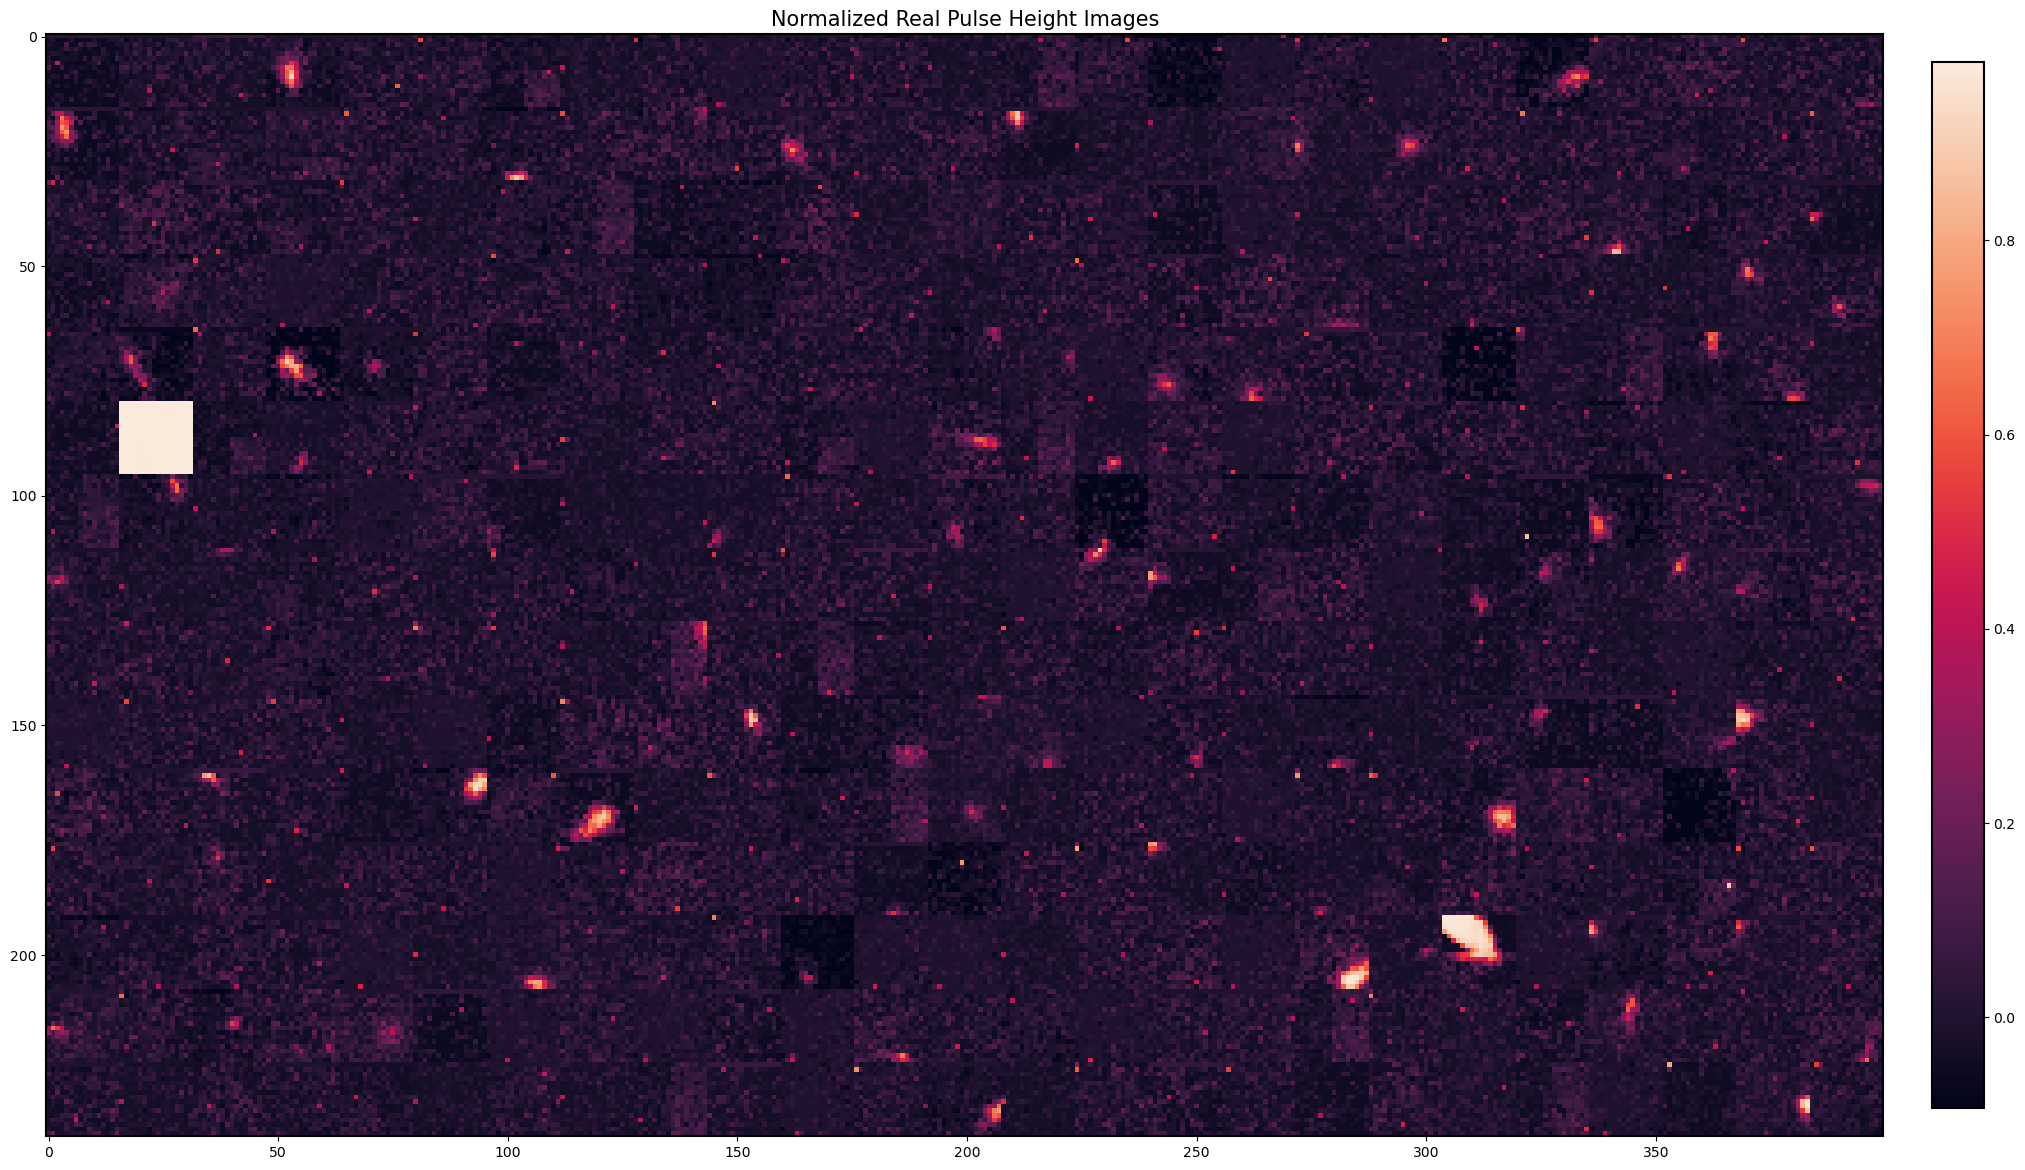

In [7]:
# Instantiate pulse-height dataset

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ToDtype(torch.float),
])

ph_dataset_config = {
    "max_ph_frames": 100_000,
    "min_max_pixel_z_score": 5,
    "max_obs_baseline_sample_size": 10_000,
    "observing_runs": [
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-07-14T04:46:21Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        }, # no bar
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-08-15T07:15:50Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        }, # faint bar
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-09-09T04:02:30Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        }, # big bar
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-09-14T04:25:43Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        }, # faint  bar
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-10-12T04:28:34Z.runtype_eng-test.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2024-05-24T04:37:30Z.runtype_sci-data.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd',
            "module_ids": 'all',
        },
    ]
}

ph_dataset = PulseHeightDataset(ph_dataset_config, transform=transform, log_level=logging.ERROR)
for i in range(150):
    next(ph_dataset.ph_gen)
show_dataset_sample(ph_dataset, nrows=15, ncols=25)

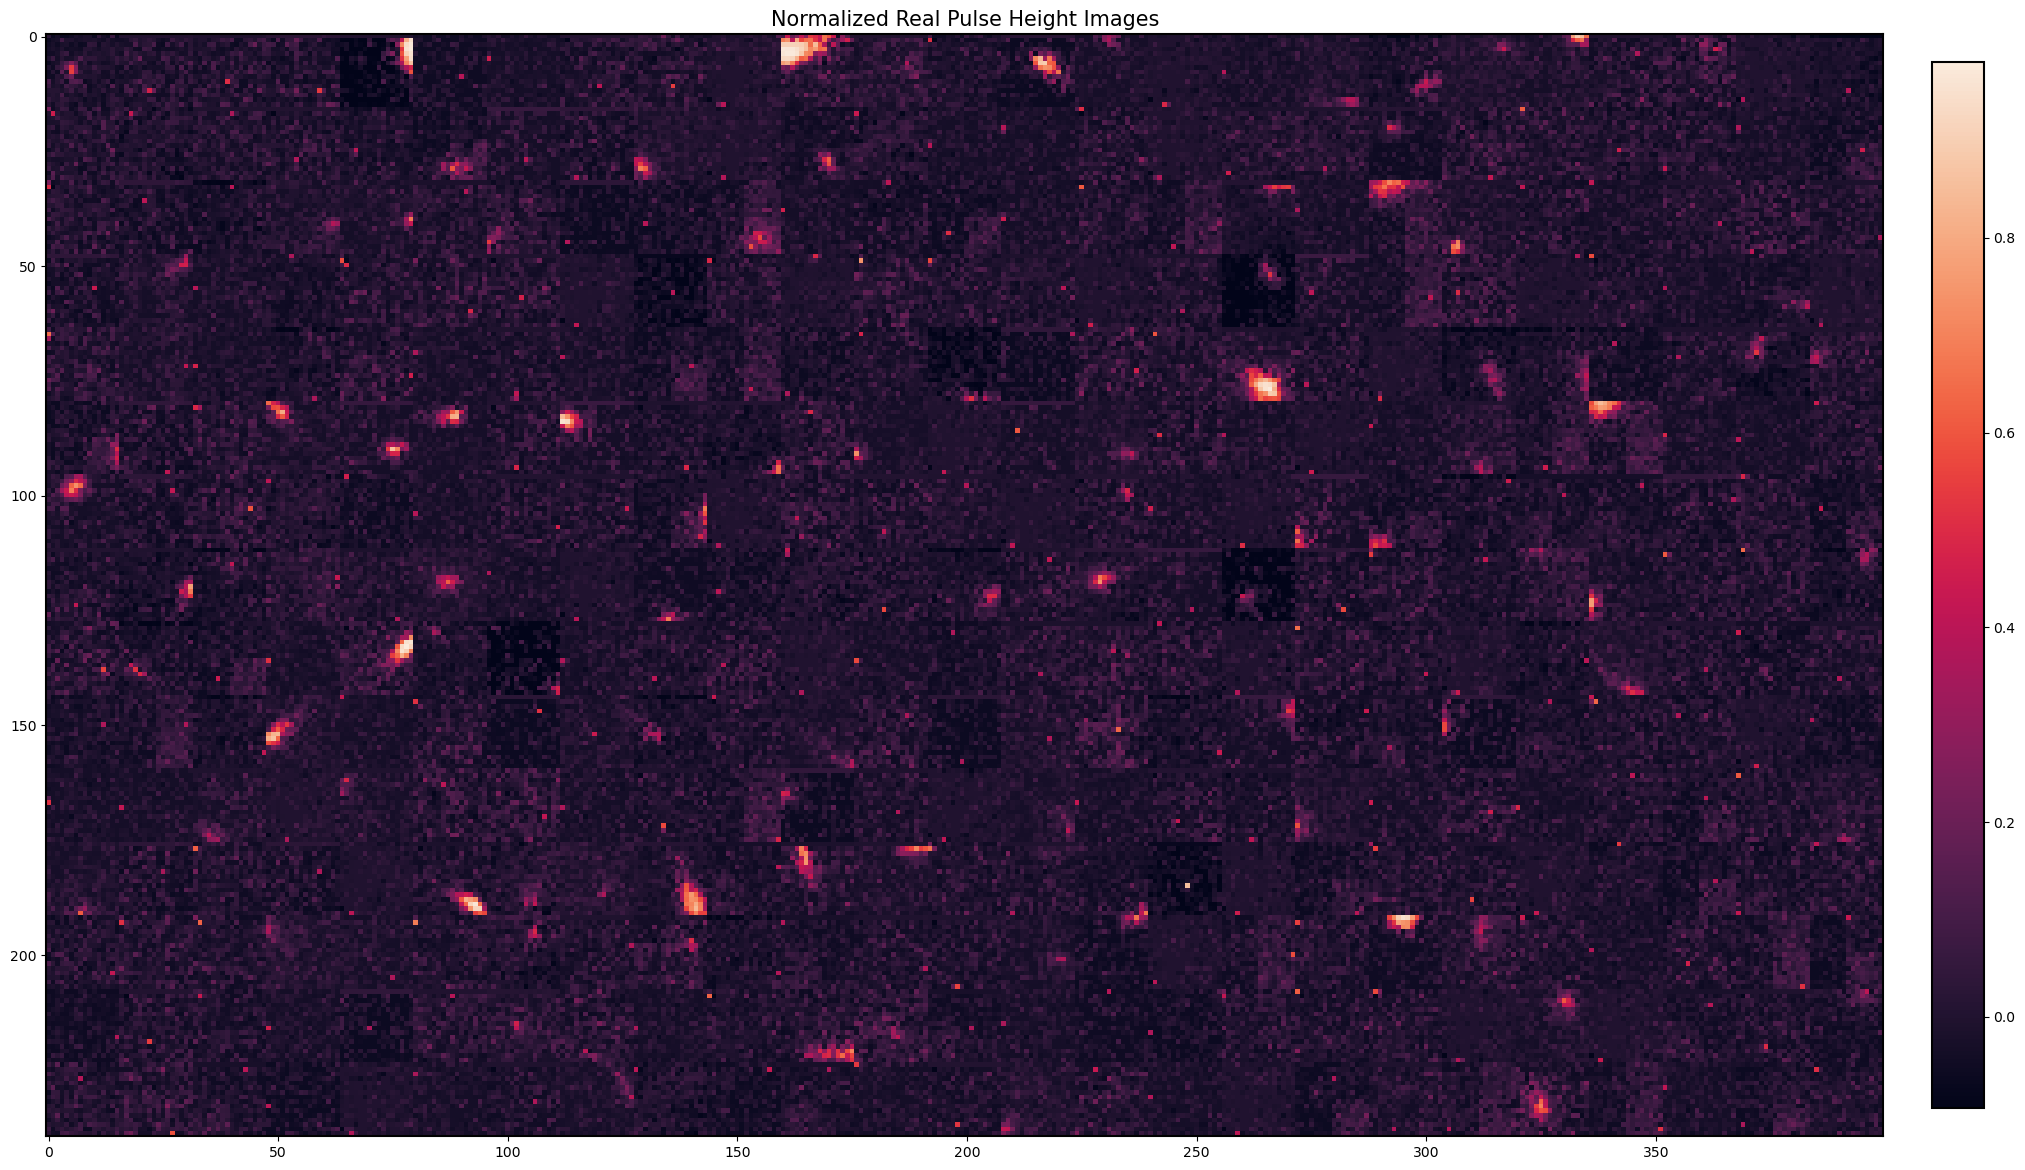

In [8]:
for i in range(150):
    next(ph_dataset.ph_gen)
show_dataset_sample(ph_dataset, nrows=15, ncols=25)

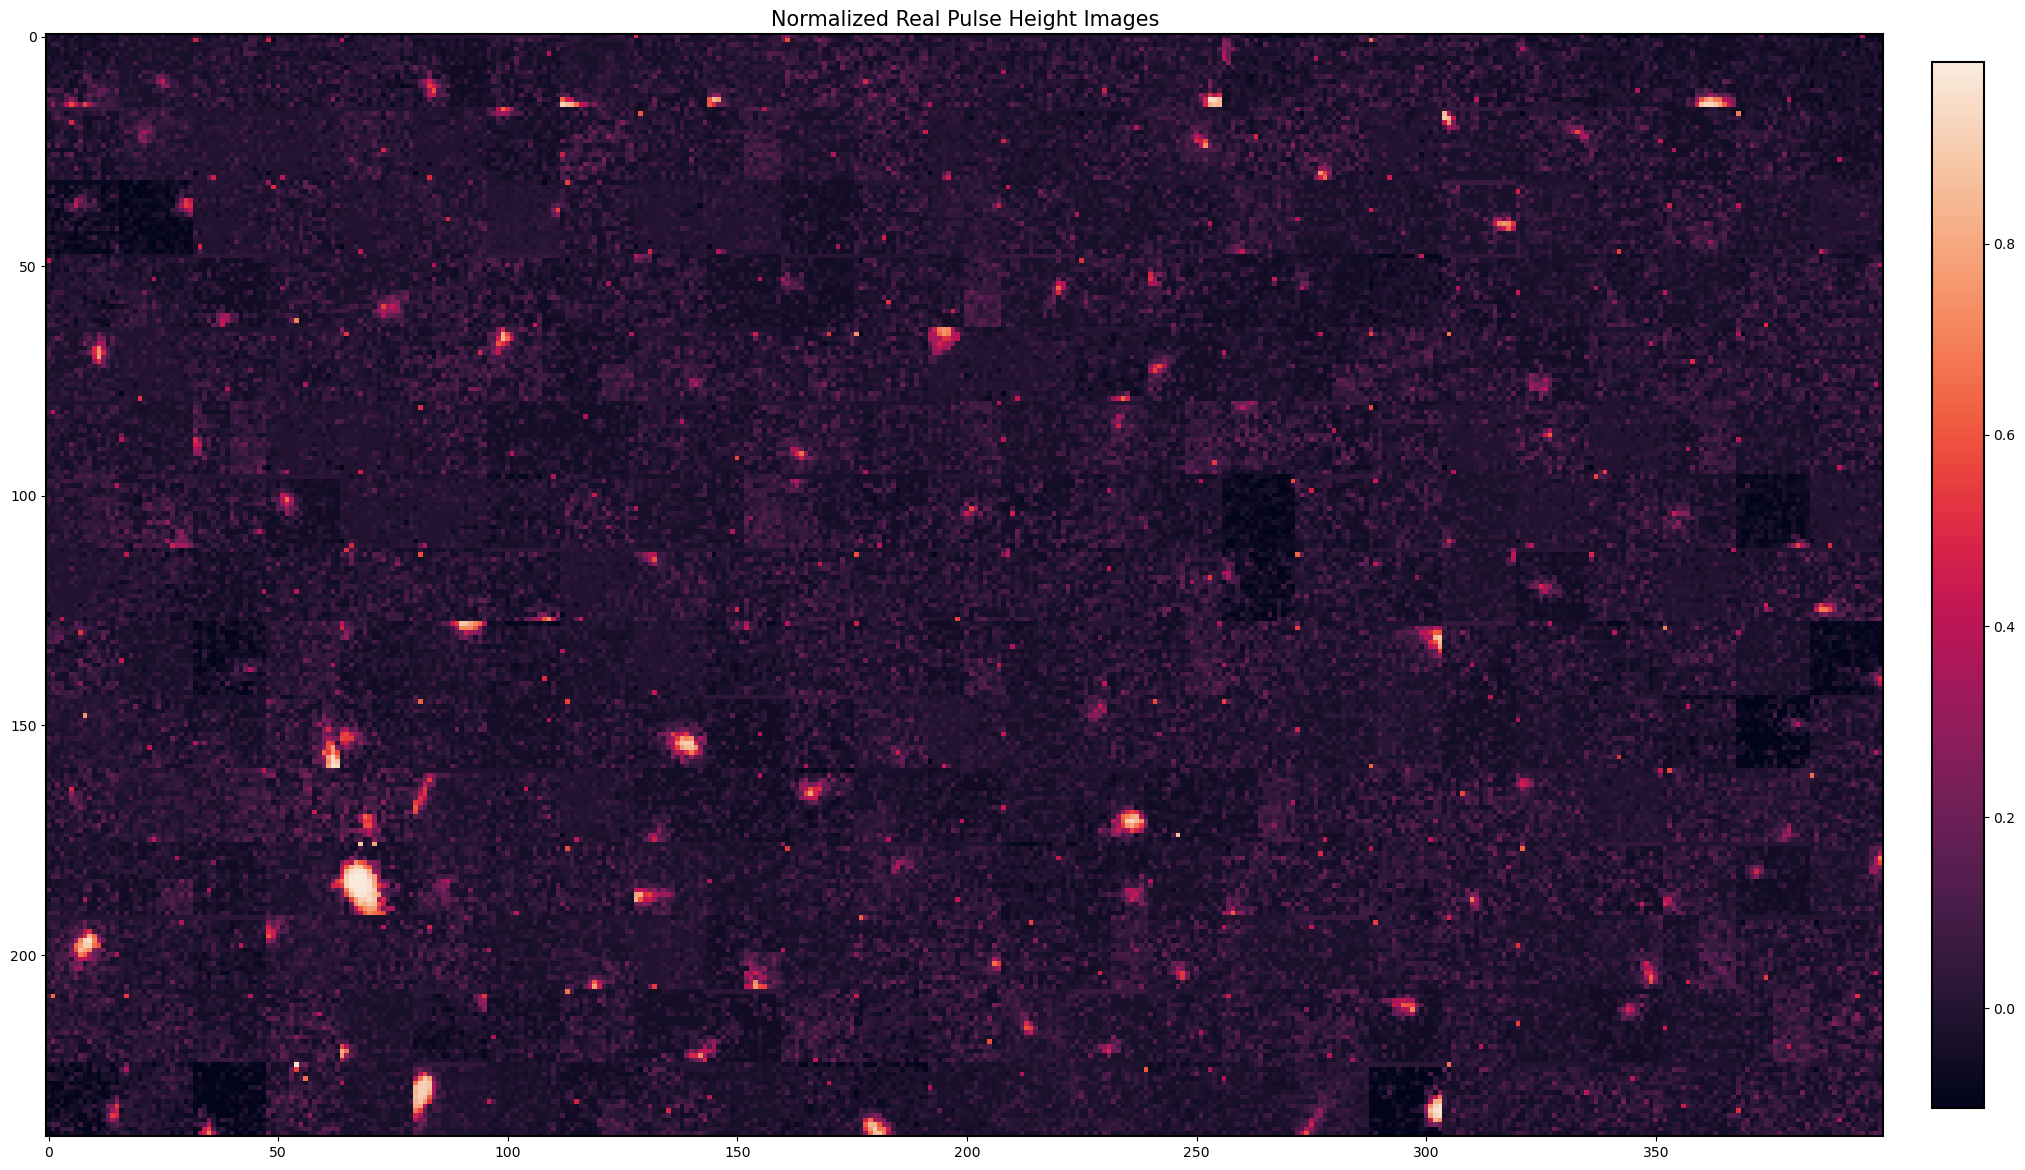

 69%|███████████████████████████████████████████████████████████████▊                             | 537/782 [00:22<00:10, 23.73batch/s]

In [ ]:
train_config = {
    # Hyperparameters: VAE architecture 
    'model': BetaVAE,
    'hidden_dim': 32,
    'latent_dim': 6,
    'beta': 1e-8, # Strength of KL-Divergence regularization. 4e-8: good for anom det
    'sparsity_weight': 1e-7, # Strength of L1 sparsity regularization
    
    # Hyperparameters: training loop
    'num_epochs': 75,
    'batch_size': 128,
    'gamma': (0.4)**(1.0 / 75), # learning rate discount factor per epoch
    'lr': 2.5e-4,
    'weight_decay': 1e-10, #0.01, #0.001, # Model weight regularization
    'verbose_loss': False,
    
    # 3D latent space visualization
    'use_norm': True,
    'max_clustering_latent_vectors': 30_000,
    'reduction_method': 'pca',
    'clustering_method': 'gmm',
    'n_clusters': 12,
    'max_gmm_components': 30,
    'anom_q': 0.995,
    'vis_anom_q': 0.995,
}

# %lprun -u 1e-3 -f train_vae train_vae(train_config, ph_dataset, seed=2025, verbose=True)
model, log_df = train_vae(train_config, ph_dataset, seed=1984, verbose=True)

In [49]:
model.seed = 1984

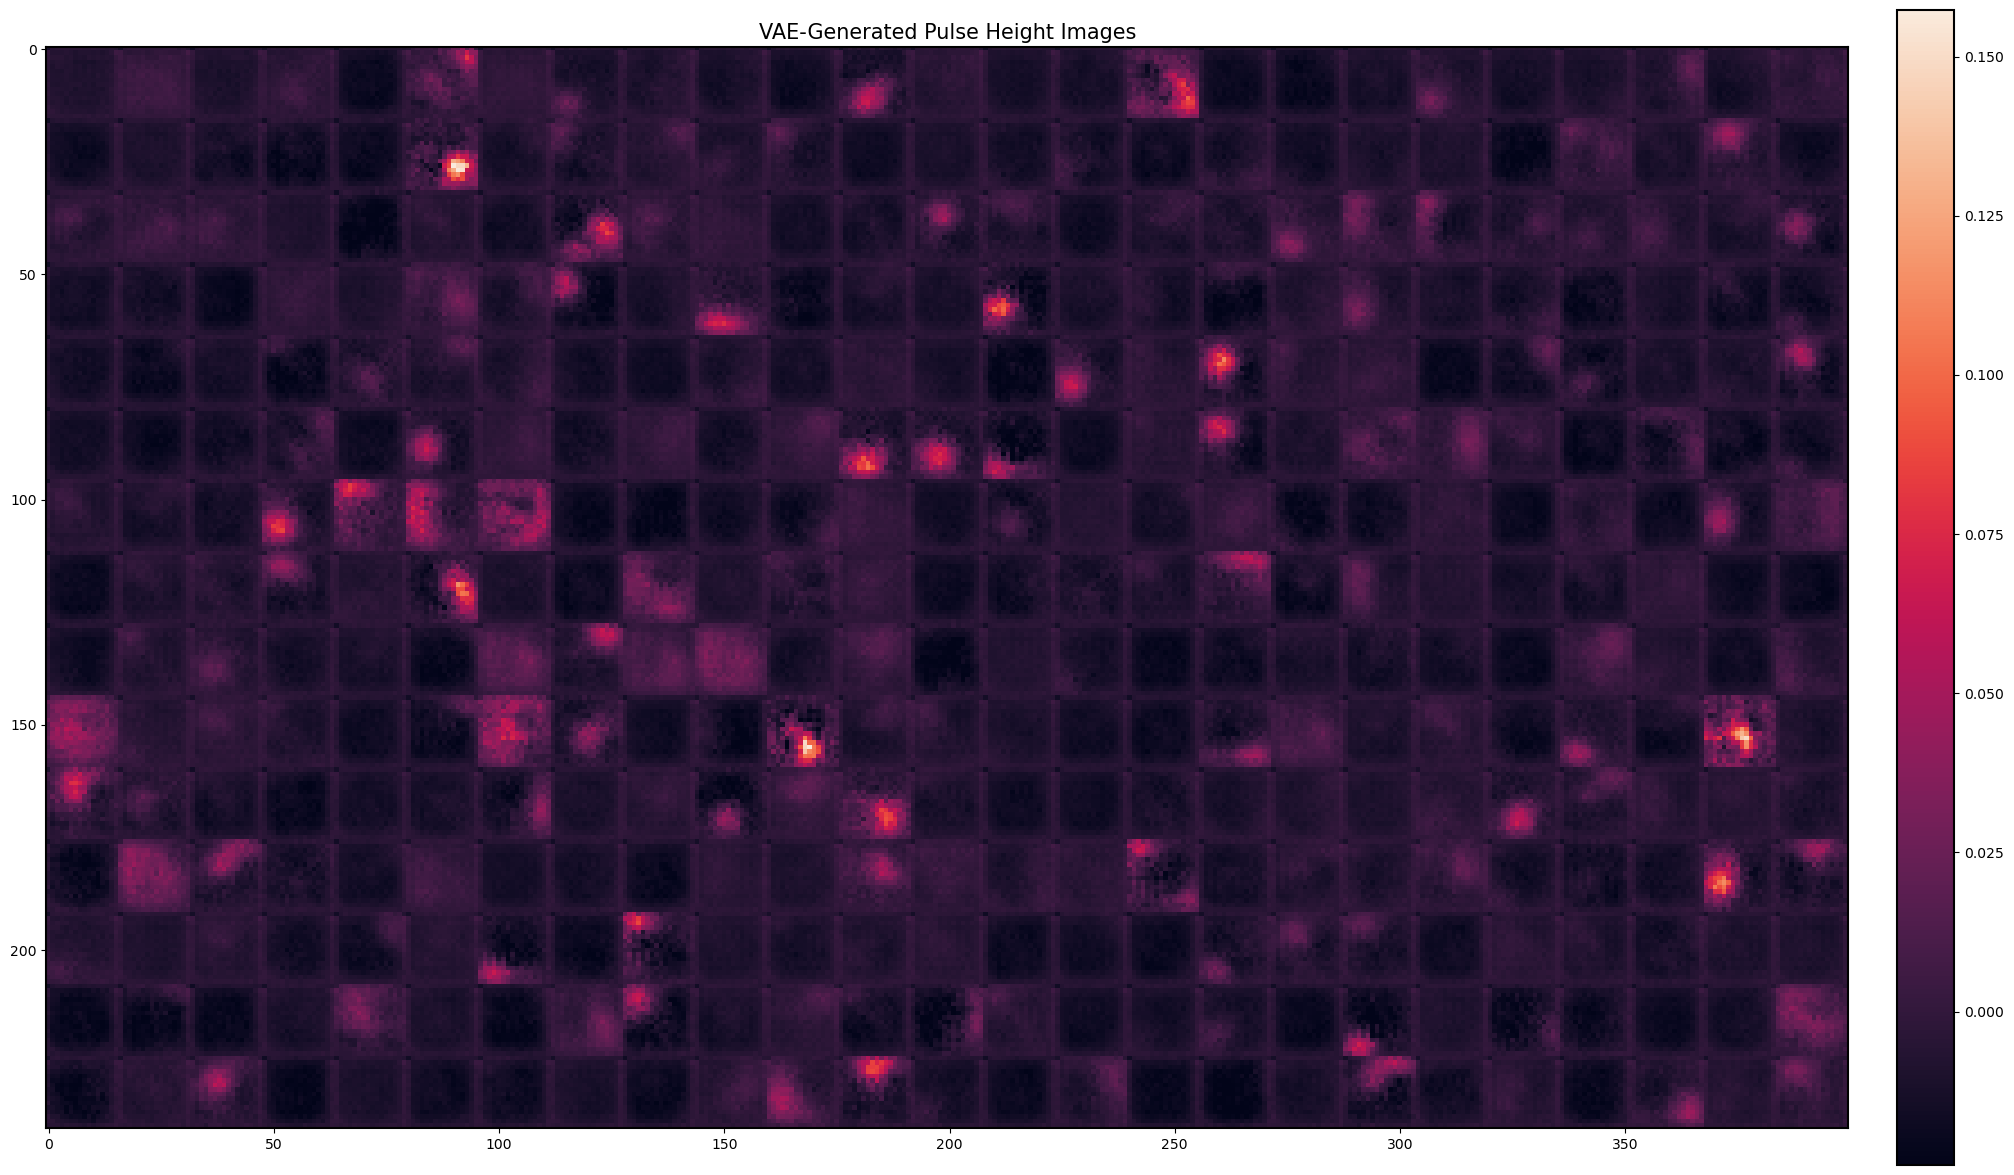

NameError: name 'visualize_latent_space_components' is not defined

In [50]:
model.seed += 1
plot_vae_sample(model, nrows=15, ncols=25)
visualize_latent_space_components(model)